In [194]:
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [195]:
# !pip3 install pandas
# !pip3 install pyarrow


### Data Fetch

In [196]:
def fetch_nsduh_data(year: int) -> Optional[pd.DataFrame]:
    """
    Fetches NSDUH data for a specified year from a remote source.

    Args:
        year (int): The year for which to fetch data.

    Returns:
        Optional[pd.DataFrame]: A pandas DataFrame with the data, or None if fetching failed.
    """
    url_placeholder = "https://www.datafiles.samhsa.gov/sites/default/files/field-uploads-protected/studies/NSDUH-{year}/NSDUH-{year}-datasets/NSDUH-{year}-DS0001/NSDUH-{year}-DS0001-bundles-with-study-info/NSDUH-{year}-DS0001-bndl-data-tsv.zip"
    
    try:
        url = url_placeholder.format(year=year)
        df = pd.read_csv(url, compression='zip', sep='\t', low_memory=False)
        return df
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")
        return None

In [197]:
def check_parquet_exists(years: List[int], output_dir: str) -> Dict[int, bool]:
    """
    Checks if Parquet files for the specified years already exist in the output directory.

    Args:
        years (List[int]): A list of years to check.
        output_dir (str): The directory where Parquet files are saved.

    Returns:
        Dict[int, bool]: A dictionary with years as keys and boolean values indicating 
                         whether the Parquet file for that year exists.
    """
    existence_check = {}
    
    for year in years:
        year_path = os.path.join(output_dir, f'year={year}')
        existence_check[year] = os.path.exists(year_path)
    
    return existence_check

In [198]:
def write_parquet(df: pd.DataFrame, year: int, output_dir: str, overwrite: bool = False) -> None:
    """
    Writes a DataFrame to Parquet format, partitioned by year.

    Args:
        df (pd.DataFrame): The DataFrame to write.
        year (int): The year of the data.
        output_dir (str): The directory where Parquet files will be saved.
        overwrite (bool): If True, overwrite existing files. If False, skip existing files.
    """
    try:
        year_dir = os.path.join(output_dir, f'year={year}')
        if overwrite and os.path.exists(year_dir):
            shutil.rmtree(year_dir)  # Remove existing directory to start fresh

        df['year'] = year  # Add the year column for partitioning
        # Write data to Parquet format with partitioning
        df.to_parquet(output_dir, partition_cols=['year'], index=False)
        
        print(f"Data for year {year} successfully saved to Parquet format in {output_dir}")
    except Exception as e:
        print(f"Error saving data to Parquet for year {year}: {e}")

In [199]:
def data_fetch(years_to_fetch: List[int], output_dir: str, overwrite: bool = False) -> None:
    """
    Fetches NSDUH data for specified years and saves it to Parquet format, one year at a time.

    Args:
        years_to_fetch (List[int]): A list of years for which to fetch data.
        output_dir (str): The directory where Parquet files will be saved.
        overwrite (bool): If True, overwrite existing files. If False, skip existing files.
    """
    try:
        for year in years_to_fetch:
            if not overwrite and os.path.exists(os.path.join(output_dir, f'year={year}')):
                print(f"Data for year {year} already exists. Skipping.")
                continue

            df = fetch_nsduh_data(year)
            if df is not None:
                print(f"Successfully fetched data for year: {year}")
                write_parquet(df, year, output_dir, overwrite)
                del df  # Remove the DataFrame from memory
                gc.collect()  # Force garbage collection

        print("All requested years processed.")
    except Exception as e:
        print(f"An unexpected error occurred in the data_fetch function: {e}")

In [200]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames

In [201]:
import pandas as pd

if __name__ == "__main__":
    # Example usage
    years = [2015, 2016, 2017, 2018, 2019] 
    output_directory = "./data/DS/NSDUH"
    
    # Fetch and save data
    data_fetch(years, output_directory, overwrite=False)

    # Initialize an empty DataFrame to hold all data
    df = pd.DataFrame()

    # Read saved data and concatenate into df
    for year in years:
        df_year = read_parquet(output_directory, [year])
        if year in df_year:
            #print(f"Data for year {year}:")
            #print(df_year[year].head())
            # Concatenate the current year's DataFrame to df
            df = pd.concat([df, df_year[year]], ignore_index=True)

    # Output the combined DataFrame
    #print("Combined DataFrame:")
    #print(df.head())


Data for year 2015 already exists. Skipping.
Data for year 2016 already exists. Skipping.
Data for year 2017 already exists. Skipping.
Data for year 2018 already exists. Skipping.
Data for year 2019 already exists. Skipping.
All requested years processed.


### EDA

### Hypothesis 1: Does Ciggratte Smoking a cause for mental health?

Question we will be answering:
1. Does smoking cigratte have any effect on mental heath?
2. if smoking ciggratee doesn't cause the mental health then is it the enviromental factor.
3. Which section of society is most sussetible to depression because of Smoking

Hypothesis Space: 

We will take only those people who smoke ciggrate and no alchol or drugs. 
We can divide them into 2 part:
1. People who smoke ciggratee and have tried drugs but never misued as it's beleived that if someone tried cigratee then they might have tried alchol or any other intoxicant.
2. People who smokes but never tried alcohol or drugs 

We need to compare these 2 categogy and see the effect of ciggratte on sucudal thoughts/depression.
In case ciggratte is no the factor then mostly society is and so we need to find how people think about smoking cigratte in different section of society.

Note: We consider "smokers" as People who smoke atlest 10 days in a month.

Note: It's proven fact that smoking causes health issue and withdrawl symptoms after leaving smoking causes anxiety and depression. In this hypothesis we are considering people who are still smoking and smoking it part of their normal life.

In [202]:
data_frame = df
# This filter have people who can be smoker but never in life misused alchol or drugs, 
# and maybe have tried or taken for some use
# People have tried drugs like for medical purpose but never have misused. eg: Even heroine is sometimes used for painrelief
df_smoker_no_misuse = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (
        ((data_frame['CIG30USE'] >= 10) & (data_frame['CIG30USE'] <= 30)) |
        (data_frame['CIG30USE'] == 91)
    ) &
    (data_frame['PNRNMFLAG'] == 0) &
    (data_frame['TRQNMFLAG'] == 0) &
    (data_frame['STMNMFLAG'] == 0) &
    (data_frame['SEDNMFLAG'] == 0) &
    (data_frame['TQSDNMFLAG'] == 0) &
    (data_frame['PSYCHFLAG'] == 0) &
    (data_frame['OPINMYR'] == 0) & 
    (data_frame['HVYDRKMON'] == 0)  # No heavydeinking/ misuse
]

# This filter have people who can be smmoker but never have even tried alchol or dugs in life
df_smoker_neverdrugs = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (
        ((data_frame['CIG30USE'] >= 10) & (data_frame['CIG30USE'] <= 30)) | # smoke 10-30 days a month
        (data_frame['CIG30USE'] == 91) # no Ciggratte
    ) &
    (data_frame['ILLALCFLG'] == 0) # no alchol and drug ever in life
] 

df_smoker_no_misuse['CIG30USE'] = df_smoker_no_misuse['CIG30USE'].apply(lambda x: 1 if 1 <= x <= 30 else 0)
df_smoker_neverdrugs['CIG30USE'] = df_smoker_neverdrugs['CIG30USE'].apply(lambda x: 1 if 1 <= x <= 30 else 0)
df_smoker_no_misuse['CIG30USE'] = df_smoker_no_misuse['CIG30USE'].replace(91, 0)
df_smoker_neverdrugs['CIG30USE'] = df_smoker_neverdrugs['CIG30USE'].replace(91, 0)

df_result_smoker_no_misuse = df_smoker_no_misuse.groupby(['INCOME', 'CIG30USE']).agg(
    sucide_mean=('SUICTHNK', 'mean')
).reset_index()
df_result_smoker_neverdrugs = df_smoker_neverdrugs.groupby(['INCOME', 'CIG30USE']).agg(
    sucide_mean=('SUICTHNK', 'mean')
).reset_index()



In [203]:
df_ciggratte_view = data_frame[
    (data_frame['YEPPKCIG'] >= 1) & (data_frame['YEPPKCIG'] <= 3)
] 
result_df_ciggratte_view = df_ciggratte_view.groupby(['INCOME']).agg(
    ciggratte_view=('YEPPKCIG', 'mean')
).reset_index()

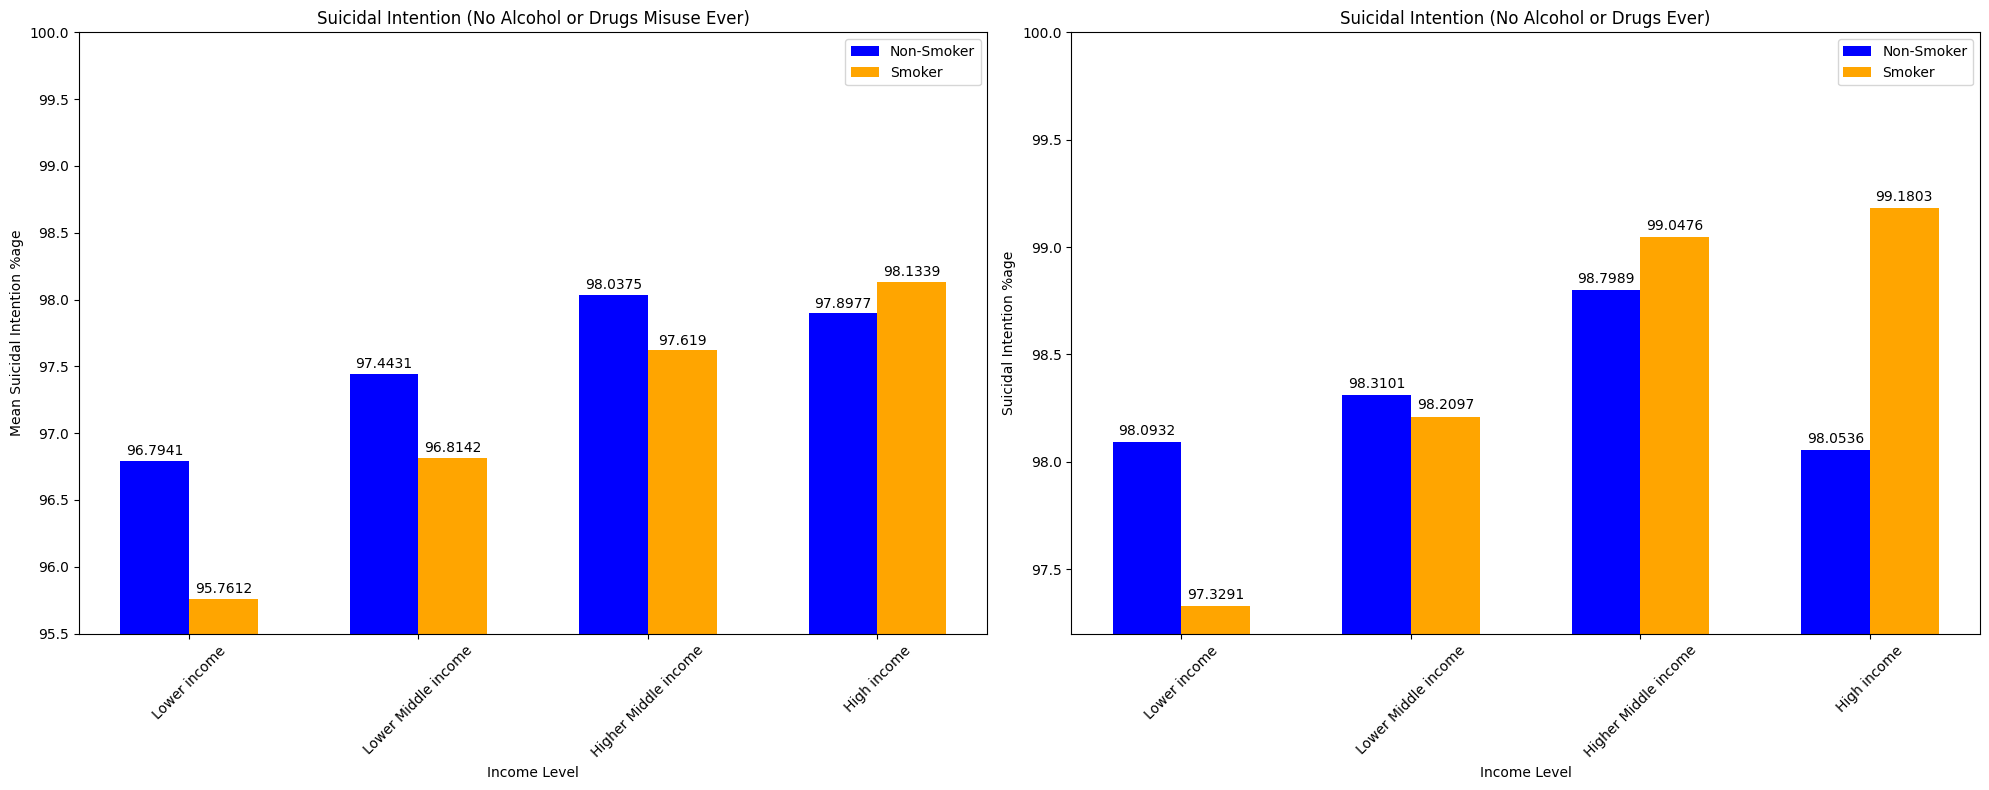

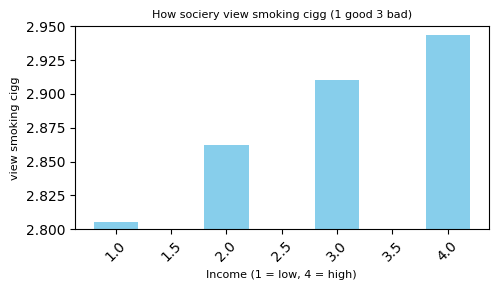

In [204]:
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size and layout for subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Define the mapping for CIG30USE
cig_labels = {0: "Non-Smoker", 1: "Smoker"}
income_labels = {1: "Lower income", 2: "Lower Middle income", 3: "Higher Middle income", 4: "High income"}

# Prepare data for result1
result1_pivot = df_result_smoker_no_misuse.pivot(index='INCOME', columns='CIG30USE', values='sucide_mean').fillna(0)

# Bar positions for result1
bar_width = 0.3
indices1 = np.arange(len(result1_pivot))

# Plot for result1
bars1 = ax[0].bar(indices1 - bar_width/2, result1_pivot[0]*50, bar_width, label='Non-Smoker', color='blue')
bars2 = ax[0].bar(indices1 + bar_width/2, result1_pivot[1]*50, bar_width, label='Smoker', color='orange')

ax[0].set_title('Suicidal Intention (No Alcohol or Drugs Misuse Ever)')
ax[0].set_xlabel('Income Level')
ax[0].set_ylabel('Mean Suicidal Intention %age')
ax[0].set_xticks(indices1)
ax[0].set_xticklabels([income_labels[i] for i in result1_pivot.index], rotation=45)
ax[0].legend()
ax[0].set_ylim(95.5, 100)

# Add bar labels above each bar
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')

# Prepare data for result2
result2_pivot = df_result_smoker_neverdrugs.pivot(index='INCOME', columns='CIG30USE', values='sucide_mean').fillna(0)

# Bar positions for result2
indices2 = np.arange(len(result2_pivot))

# Plot for result2
bars3 = ax[1].bar(indices2 - bar_width/2, result2_pivot[0]*50, bar_width, label='Non-Smoker', color='blue')
bars4 = ax[1].bar(indices2 + bar_width/2, result2_pivot[1]*50, bar_width, label='Smoker', color='orange')

ax[1].set_title('Suicidal Intention (No Alcohol or Drugs Ever)')
ax[1].set_xlabel('Income Level')
ax[1].set_ylabel('Suicidal Intention %age')
ax[1].set_xticks(indices2)
ax[1].set_xticklabels([income_labels[i] for i in result2_pivot.index], rotation=45)
ax[1].legend()
ax[1].set_ylim(97.2, 100)
# Add bar labels above each bar
for bar in bars3 + bars4:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()
labels = result_df_ciggratte_view['INCOME']
sizes = result_df_ciggratte_view['ciggratte_view']

labels = result_df_ciggratte_view['INCOME']
sizes = result_df_ciggratte_view['ciggratte_view']

plt.figure(figsize=(5, 3))
plt.bar(labels, sizes, color='skyblue',width=0.4)

plt.title('How sociery view smoking cigg (1 good 3 bad)', fontsize=8)
plt.xlabel('Income (1 = low, 4 = high)', fontsize=8)
plt.ylabel('view smoking cigg', fontsize=8)

plt.xticks(rotation=45)
plt.ylim(2.8, 2.95)
plt.tight_layout()
plt.show()


### OBSERVATION
High earning > $75000

low earning < $20000

From both of the graph we can see that Sucidal intention is more for non smokers for lower family income people. where as with increase with family income smokers tends to become more depressed. 

We can say that smoking is one of the factor for depression in high earning people but For lower earning people smoking becomes a tool to curb depression. 

From the 3rd graph which shows how different income society thinks of smoking ciggratte, we can see that people with lower incomer does't see it as bad of a habit as compared to high income society. So we can believe that it's the society which is the factor for depression rather than ciggratte.

(FIg 3 shows On average high income people/ society will strongly disappove of smoking and this stigma will create isolation for smokers but whereas in lower income group also disapproves but not as stongly as high income.)


In lower income society as smoking views are little lineant people will meet and talk over ciggratee and share their feelings, whereas in high socity as smokers might get isolated by the people because of their right views on smoking causing depressed person to go into more depression.



### CONCLUSION
1. Nicotine/Smoking is not the main cause of depression, it's the socital view in which a person is born and lives in.
2. A high earning person should avoid cigratte smoking as much a possible.


In conclusion, it's the socital view that casues a smoker to go into depression. 
hence, Ciggratte smoking is an Indirect factor of depression

Note: It's proven fact that smoking causes health issue and withdrawl symptoms after leaving smoking causes anxiety and depression. In this hypothesis we are considering people who are still smoking and smoking it part of their normal life.

This is mostly dues to social stigma



We can see in low income and high income 
people with family income from 20k to 70k and are into smoking have more sucidal feelings than non Smoker.
Whereas smokers with more lower and higher income feels less sucidal on average than non Smoker.
PNRNMFLAG
TRQNMFLAG
STMNMFLAG
SEDNMFLAG
TQSDNMFLAG
PSYCHFLAG
OPINMYR
HVYDRKMON

####

#### HYPOTHESIS 2: Does Believing in god lowers rate of sucidal thoughts?
Questions we will be answering:
1. Is RELIGIOUS Belief one of the factor of Mental health?
2. if Religious is one of the factor, then will believing in GOD help you fight depression?

Hypthothesis space: 
Some people believe that being religious can reduce stress and negative emotions, while others argue that faith can increase stress. This is because people may feel pressured to adhere to strict religious practices that are difficult to follow.

Note: In our hypothesis we will take only those people who have never done drugs or alcohol in life

   SNRLGIMP  count
0         1   3699
1         2   2121
2         3   7648
3         4  12066


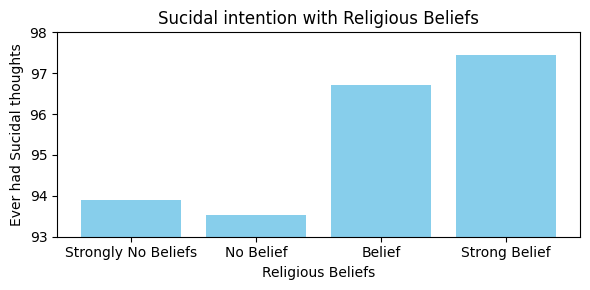

In [205]:
df_religious_belief = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) & # sucidal thoughts
    (data_frame['SNRLGIMP'] >= 1) & (data_frame['SNRLGIMP'] <= 4) & # relifious belief
    (data_frame['ILLALCFLG'] == 0) # no alchol and drug ever in life
] 
df_result_religious_belief = df_religious_belief.groupby(['SNRLGIMP']).agg(
    SUICTHNK_mean=('SUICTHNK', 'mean'),
    count=('SUICTHNK', 'count')
).reset_index()
belief_mapping = {
    1: 'Strongly No Beliefs',
    2: 'No Belief',
    3: 'Belief',
    4: 'Strong Belief'
}
print(df_result_religious_belief[['SNRLGIMP','count']])
# count shows that we have suffieient data to perform analysis

df_result_religious_belief['Belief_Labels'] = df_result_religious_belief['SNRLGIMP'].map(belief_mapping)
plt.figure(figsize=(6, 3))
plt.bar(df_result_religious_belief['Belief_Labels'], (df_result_religious_belief['SUICTHNK_mean']-1)*100, color='skyblue')
plt.xlabel('Religious Beliefs')
plt.ylabel('Ever had Sucidal thoughts')
plt.title('Sucidal intention with Religious Beliefs')
plt.xticks(rotation=0)
plt.ylim(93, 98)
plt.tight_layout()
plt.show()

##### OBSERVATION
From the Graph/result we can See that people with Stong religious belief have are more sussiptle to sucidal than the people with less to absolutly no religious belief. 
We can see that there is drastic increase in sucidal thought in religiou than non religious people.

#### CONCLUSION
1. Yes, religious belief is an important factor for depression and sucidal thoughts.
2. Having religious belief makes you more sussiptable to depression
3. People who doesn't have religious belief but also doesn't strongly oppose to it are the one with least sucidal thought.
4. Religious people may experience higher levels of depression due to the pressure to follow demanding religious practices. Failure to meet these expectations can lead to feelings of shame, which are worsened by societal judgment, pushing them deeper into isolation and depression. Some people with mental illnesses may seek help from god rather than seek medical attention, making them more vulnerable to increasing depression.

Note: This is just data driven insights.

###

### HYPOTHESIS 3: Is having or not having insurance a factor for mental health?

Questions we will be Answering:
1. Does having an insurance makes you less susspitble to depression?
2. How does an insurance play a role in society in regards to mental health?
3. How does insurance effects mental health of different section of society?

Hypothesis Space: 

We will look into different category of people who are non alcholic and never did drugs and check their depression and compare it with respect to insurance. If insurance is a factor for mental health then it probably due to fact that having an insurance gives feeling of safety in case of emergency.

In [206]:
def categorize(row):
    if row['column_name'] == 'INCOME':
        if row['weighted_mean_value'] < 2:
            return 'Low income'
        elif 2 <= row['weighted_mean_value'] < 3:
            return 'Middle income'
        else:
            return 'High income'
    elif row['column_name'] == 'IRINSUR4':
        return 'Has Insurance' if row['weighted_mean_value'] < 1.5 else 'Does Not Have Insurance'
    elif row['column_name'] == 'IRWRKSTAT':
        if row['weighted_mean_value'] < 2:
            return 'Working'
        elif 2 <= row['weighted_mean_value'] < 3:
            return 'Not Working/Part-time'
    elif row['column_name'] == 'COUTYP4':
        if row['weighted_mean_value'] < 2:
            return 'Metro'
        elif row['weighted_mean_value'] < 2.5:
            return "Small metro"
        else:
            return "Nonmetro"
    return ''

In [207]:
insurance_depression_high = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (data_frame['IRINSUR4'] >= 1) & (data_frame['IRINSUR4'] <= 2) &
    (data_frame['IRWRKSTAT'] >= 1) & (data_frame['IRWRKSTAT'] <= 3) &
    (data_frame['INCOME'] >= 1) & (data_frame['INCOME'] <= 4) &
    (data_frame['ILLALCFLG'] == 1)
] 
result_insurance_depression_high = insurance_depression_high.groupby(['IRINSUR4','IRWRKSTAT','COUTYP4','INCOME']).agg(
    count=('ILLALCFLG', 'count'), #ILLALCFLG
    sucide=('SUICTHNK', 'mean')
).reset_index()
result_insurance_depression_high_filtered = result_insurance_depression_high[(result_insurance_depression_high['count'] > 50)&(result_insurance_depression_high['sucide']>1.93)].reset_index(drop=True).head(10)
result_insurance_depression_high_filtered = result_insurance_depression_high_filtered.sort_values(by='sucide', ascending=False).reset_index(drop=True)
columns_to_multiply = result_insurance_depression_high_filtered.columns.difference(['count'])  # Select all columns except 'count'
multiplied_df = result_insurance_depression_high_filtered[columns_to_multiply].multiply(result_insurance_depression_high_filtered['count'], axis=0)
sum_multiplied = multiplied_df.sum()
sum_count = result_insurance_depression_high_filtered['count'].sum()
weighted_mean_depression_high_filtered = (sum_multiplied / sum_count).to_frame(name='weighted_mean_value').reset_index()
weighted_mean_depression_high_filtered.columns = ['column_name', 'weighted_mean_value']
weighted_mean_depression_high_filtered['category'] = weighted_mean_depression_high_filtered.apply(categorize, axis=1)

In [208]:
insurance_depression_low = data_frame[
    (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
    (data_frame['IRINSUR4'] >= 1) & (data_frame['IRINSUR4'] <= 2) &
    (data_frame['IRWRKSTAT'] >= 1) & (data_frame['IRWRKSTAT'] <= 3) &
    (data_frame['INCOME'] >= 1) & (data_frame['INCOME'] <= 4) &
    (data_frame['ILLALCFLG'] == 1) 
] 
result_insurance_depression_low = insurance_depression_low.groupby(['IRINSUR4','IRWRKSTAT','COUTYP4','INCOME']).agg(
    count=('ILLALCFLG', 'count'), #ILLALCFLG
    sucide=('SUICTHNK', 'mean')
).reset_index()

result_insurance_depression_low_filtered = result_insurance_depression_low[(result_insurance_depression_low['count'] > 50)].reset_index(drop=True)
result_insurance_depression_low_filtered = result_insurance_depression_low_filtered.sort_values(by='sucide', ascending=True).reset_index(drop=True).head(20)

columns_to_multiply = result_insurance_depression_low_filtered.columns.difference(['count'])  # Select all columns except 'count'
multiplied_df = result_insurance_depression_low_filtered[columns_to_multiply].multiply(result_insurance_depression_low_filtered['count'], axis=0)
sum_multiplied = multiplied_df.sum()
sum_count = result_insurance_depression_low_filtered['count'].sum()
weighted_mean_depression_low_filtered = (sum_multiplied / sum_count).to_frame(name='weighted_mean_value').reset_index()
weighted_mean_depression_low_filtered.columns = ['column_name', 'weighted_mean_value']
weighted_mean_depression_low_filtered['category'] = weighted_mean_depression_low_filtered.apply(categorize, axis=1)
# need to take weighted calcualtion.

  column_name  weighted_mean_value               category
0     COUTYP4             2.072092            Small metro
1      INCOME             1.296322             Low income
2    IRINSUR4             1.161810          Has Insurance
3   IRWRKSTAT             2.223530  Not Working/Part-time
4      sucide             1.879995                       
  column_name  weighted_mean_value       category
0     COUTYP4             1.711644          Metro
1      INCOME             3.387637    High income
2    IRINSUR4             1.000000  Has Insurance
3   IRWRKSTAT             1.045200        Working
4      sucide             1.955292               
Small metro,Low income,Has Insurance,Not Working/Part-time, Metro,High income,Has Insurance,Working,
Small metro,Low income,Has Insurance,Not Working/Part-time, 0.8799949096462205
Metro,High income,Has Insurance,Working, 0.9552915685113565


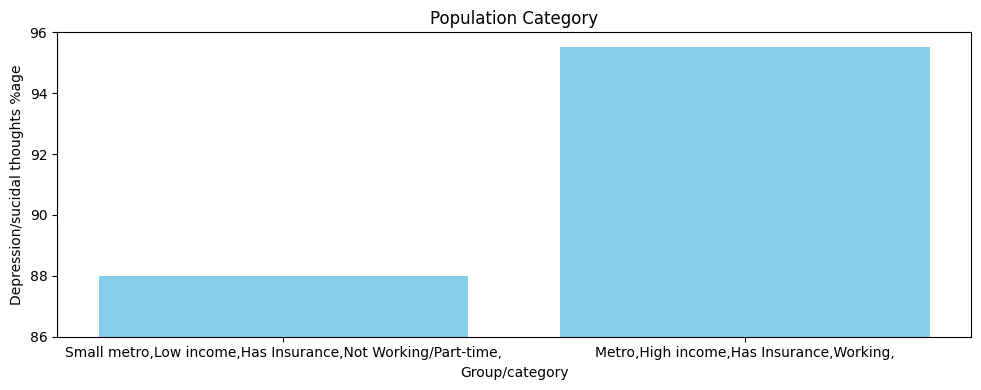

In [209]:
print(weighted_mean_depression_low_filtered)
print(weighted_mean_depression_high_filtered)
x_value_low = ','.join(cat for cat in weighted_mean_depression_low_filtered['category'])
x_value_high= ','.join(cat for cat in weighted_mean_depression_high_filtered['category'])
print(x_value_low,x_value_high)
high_sucide_row = weighted_mean_depression_high_filtered[weighted_mean_depression_high_filtered['column_name'] == 'sucide']
high_sucide_value=(high_sucide_row['weighted_mean_value'].values[0])
low_sucide_row = weighted_mean_depression_low_filtered[weighted_mean_depression_low_filtered['column_name'] == 'sucide']
low_sucide_value = (low_sucide_row['weighted_mean_value'].values[0])
print(x_value_low,low_sucide_value-1)
print(x_value_high,high_sucide_value-1)

x_labels = [x_value_low, x_value_high]
y_values = [(low_sucide_value-1)*100, (high_sucide_value-1)*100]

plt.figure(figsize=(10, 4))
plt.bar(x_labels, y_values, color='skyblue') 

# Set title and labels
plt.title('Population Category')  
plt.xlabel('Group/category') 
plt.ylabel('Depression/sucidal thoughts %age') 
plt.xticks(rotation=0) 
plt.tight_layout() 
plt.ylim(86, 96)
plt.show()

### OBSERVATION
The Graph above has 2 plot one shows category with least depression and another shows category with highest depression.
1. People who are rich, lives in metro, is working and have insurance are the most depressed class
2. people who has low income, lives in small metro, is either non working or partime worker but has the insurance are the least depressed class or class with least sucidal thoughts. 

### CONCLUSION
1. A person having low income and no/parttime job is least depressed category because of the insurance
2. We can believe that having insurance gives them a hope of safety, and they are not tensed about their medical coverage in case of emergency.(only 85% of this population category have insurance)
3. Rich and high society people are most depressed, even though they have 100% of them insurance. we can conclude that as they have money insurance is the least factor they consider, as by default they can afford it(As can be seen from table data, that 100% of rich population have insurance)

In conclusion, Insurance is indeed one of the factor that effects mental health, especially if you belong to a low income family, having an insurance will give sense of safety and less susceptible to depression and sucidal thoughts.

####

#### HYPOTHESIS 4: Which small behavourial factor of parents effects thier kids mental health??

Questions we will be anwering:
1. Which all small behavourial factors can cause severe mental effects on children, these small behavorial patterns are something that seems useless to parents or us but many effects kids. eg: letting them watch tv, phone etc.
2. Which of these behavourial factors are important factor of mental health? and which are not and can be neglected.
3. We will be taking few of such factors in consideration like help kids in homework, check thier homework, make kids to do house chorus, limit Tv/phones, limit games during school night, fight with them/ scold them, tell then they did a good job and you are proud of them.

Hypothesis Space:
We will check all combination of behaviour and find out the best behaviour pattern a parent should follow and compare it with worse behaviour and figure out those pattern which have got the most severe effects on childs mental health.

In [210]:
data_behavourial = data_frame[
    (data_frame['PARCHKHW'] >= 1) & (data_frame['PARCHKHW'] <= 2) &
    (data_frame['PARHLPHW'] >= 1) & (data_frame['PARHLPHW'] <= 2) &
    (data_frame['PRCHORE2'] >= 1) & (data_frame['PRCHORE2'] <= 2) &
    (data_frame['PRLMTTV2'] >= 1) & (data_frame['PRLMTTV2'] <= 2) &
    (data_frame['PARLMTSN'] >= 1) & (data_frame['PARLMTSN'] <= 2) &
    (data_frame['PRGDJOB2'] >= 1) & (data_frame['PRGDJOB2'] <= 2) &
    (data_frame['PRPROUD2'] >= 1) & (data_frame['PRPROUD2'] <= 2) &
    (data_frame['ARGUPAR'] >= 1) & (data_frame['ARGUPAR'] <= 2) &
    (data_frame['PRTALK3'] >= 1) & (data_frame['PRTALK3'] <= 2) 
    
]
# Group by the specified columns
result_data_behavourial = data_behavourial.groupby(
    ['PARCHKHW','PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2','PRPROUD2','ARGUPAR','PRTALK3']
).agg(
    depression=('YMDELT', 'mean'),
    count=('YMDELT', 'count')
).reset_index()
result_best_behavourial_filtered = result_data_behavourial[(result_data_behavourial['count'] > 100) & (result_data_behavourial['depression'] > 1.75)].reset_index(drop=True)

result_worse_behavourial_filtered = result_data_behavourial[(result_data_behavourial['count'] > 100) & (result_data_behavourial['depression'] < 1.5)].reset_index(drop=True)

result_best_behavourial_filtered = result_best_behavourial_filtered.sort_values(by='depression', ascending=False).reset_index(drop=True)

best_behavourial_count_1 = (result_best_behavourial_filtered == 1).sum()
best_behavourial_count_2 = (result_best_behavourial_filtered == 2).sum()

worse_behavourial_count_1 = (result_worse_behavourial_filtered == 1).sum()
worse_behavourial_count_2 = (result_worse_behavourial_filtered == 2).sum()

best_behavourial_mean_df = (best_behavourial_count_1*100 / (best_behavourial_count_1+best_behavourial_count_2)).to_frame(name='mean_value').reset_index()
worse_behavourial_mean_df = (worse_behavourial_count_1*100 / (worse_behavourial_count_1+worse_behavourial_count_2)).to_frame(name='mean_value').reset_index()
best_behavourial_mean_df.columns = ['column_name', 'mean_value']
worse_behavourial_mean_df.columns = ['column_name', 'mean_value']
best_behavourial_mean_df = best_behavourial_mean_df.dropna(subset=['mean_value'])
worse_behavourial_mean_df = worse_behavourial_mean_df.dropna(subset=['mean_value'])


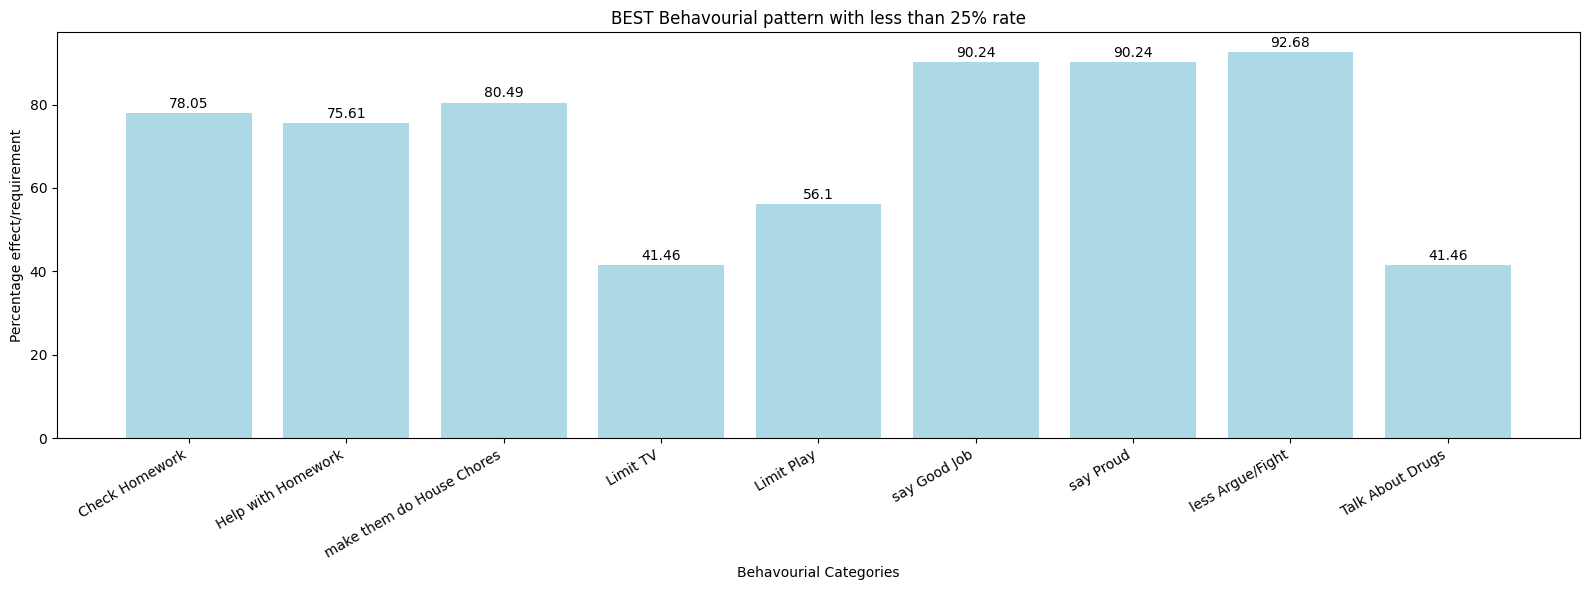

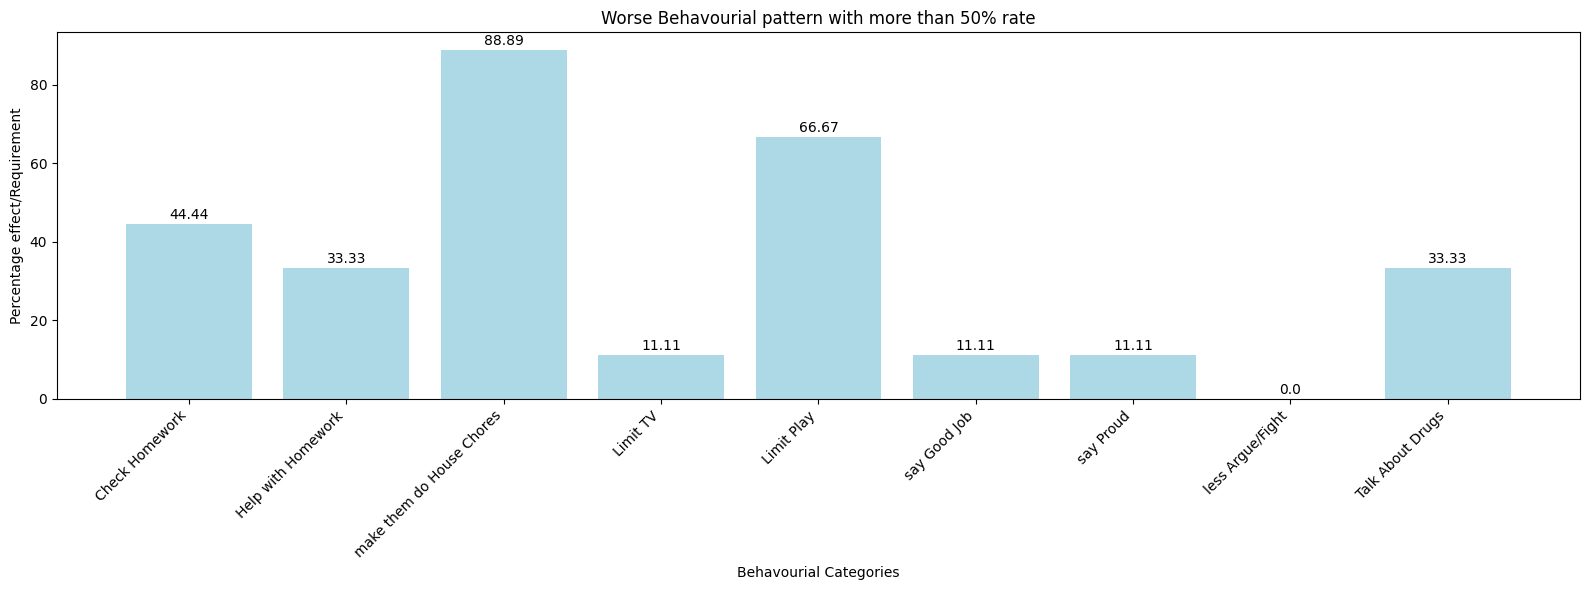

In [211]:

custom_labels = ['Check Homework', 'Help with Homework', 'make them do House Chores', 'Limit TV', 'Limit Play', 
                 'say Good Job', 'say Proud', 'less Argue/Fight', 'Talk About Drugs']

plt.figure(figsize=(16, 6))
bars = plt.bar(custom_labels, best_behavourial_mean_df['mean_value'], color='lightblue')

plt.xlabel('Behavourial Categories')
plt.ylabel('Percentage effect/requirement')
plt.title('BEST Behavourial pattern with less than 25% rate')

plt.xticks(rotation=30, ha='right')

for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x()+ bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()
plt.figure(figsize=(16, 6))
bars = plt.bar(custom_labels, worse_behavourial_mean_df['mean_value'], color='lightblue')
plt.xlabel('Behavourial Categories')
plt.ylabel('Percentage effect/Requirement') 
plt.title('Worse Behavourial pattern with more than 50% rate')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+ bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### CONCLUSION 

the two graph shows the behavourial pattern of parents and its effect of their kids. 1st graph shows best patten and second shows the wordse pattern

1. we can see that praising your kid whenever possible decreases depression by a lot and from 2nd graph we see parents who are not doing it have got more depressed kids in average
2. Limiting your kid tv/mobile and playtime moderately doesn't have severe effect on ther mental health but if you strictly limit tv/mobile time and also strictly limit their play time it might cause them to fall into depression. Hence when it comes to Playing and watching TV moderately strict restriction is fine for kids growth. 
3. Kids are happier when their parents get involved with their work like helping them with homework and checking their homeowrk but parents who are not doint it have got more depressed kids in avarage
4. for healthy mental health parents should avoid arguing with kids and find a way that they also don't get the feeling to fight to argue as it effects mental health as can be seen in above graph. Parents and kids who argue/fight with each other a lot will cause kid to fall into depression more in average. fighting/arguing less with kids have shown better mental health result.
5. From the grah we can also see that on an average parents who talks to kids about effects on intoxicant on health have better mental health kids on average. But this factor is not a major factor as there is only slight incrase

So in Conclusion, Parents Behavourial patterns which cause the mental issues are primarialy:

Important factor
1. Involvement with kids
2. Telling them they are proud of them and appreciate their effort
3. less Argument with kids

Moderate factor
1. Strictness with tv and playtime
2. let kids do the house chorus

less important factor:
1. talk about effects of intoxicant on them

###


In [212]:
# (YEPCHKHW)
# PARCHKHW Len : 1 RC-PARENTS CHECK IF HOMEWORK DONE IN PST YR
# PARHLPHW Len : 1 RC-PARENTS HELP WITH HOMEWORK IN PST YR
# (YEPCHORE)
# PRCHORE2 Len : 1 RC-PARENTS MAKE YTH DO CHORES AROUND HOUSE IN PST YR
# (YEPLMTTV)
# PRLMTTV2 Len : 1 RC-PARENTS LIMIT AMOUNT OF TV IN PST YR
# (YEPLMTSN)
# PARLMTSN Len : 1 RC-PARENTS LIMIT TIME OUT ON SCHOOL NIGHT IN PST YR, at school night if he can play more
# (YEPGDJOB)
# PRGDJOB2 Len : 1 RC-PARENTS TELL YTH HAD DONE GOOD JOB IN PST YR
# (YEPPROUD)
# PRPROUD2 Len : 1 RC-PARENTS TELL YTH PROUD OF THINGS DONE IN PST YR
# (YEYARGUP)
# (YE22)
# YETLKPAR??
# (YEPRTDNG)
# PRTALK3 Len : 1 RC-TALKED WITH PARENT ABOUT DANGER TOB/ALC/DRG
# ARGUPAR Len : 1 RC-TIMES ARGUED/HAD A FIGHT WITH ONE PARENT IN PST YR
# YMDELT (1,2) 1= having depressive episode

# mass_insurance_filter = data_frame[
#     (data_frame['SUICTHNK'] >= 1) & (data_frame['SUICTHNK'] <= 2) &
#     (data_frame['IRINSUR4'] >= 1) & (data_frame['IRINSUR4'] <= 2)
# ] 
# result_mass_insurance_filter = mass_insurance_filter.groupby(['IRINSUR4']).agg(
#     sucide=('SUICTHNK', 'mean')
# ).reset_index()
# print(result_mass_insurance_filter)
# x_labels = ['Insurance', 'No Insurance']
# y_values = result_mass_insurance_filter['sucide'].to_list()
# y_values = [(value - 1) * 100 for value in y_values]
# print(y_values)
# plt.figure(figsize=(10, 4))  # Set figure size
# plt.bar(x_labels, y_values, color='skyblue')  # Create bars
# plt.title('Population Category')  # Title of the graph
# plt.xlabel('Group/category')  # X-axis label
# plt.ylabel('Depression/sucidal thoughts %age')  # Y-axis label
# plt.xticks(rotation=0)  # Rotate x labels for better visibility
# plt.tight_layout()  # Adjust layout to prevent clipping
# plt.ylim(86, 96)
# # Display the graph
# plt.show()